In [ ]:
# Install required packages if needed
!pip install -q tensorflow numpy matplotlib seaborn pandas scipy scikit-learn pillow opencv-python mediapipe

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')
import random
import cv2
from PIL import Image
import mediapipe as mp
import zipfile
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import stats
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU available: []


In [ ]:
# Setup all necessary directories and file paths
base_dir = Path('/content')
data_dir = base_dir / 'augmented_dataset'
model_dir = base_dir / 'models'
tflite_dir = base_dir / 'tflite_models'
results_dir = base_dir / 'evaluation_results'
zip_path = base_dir / 'augmented_dataset.zip' # Define zip file path

# Create directories
for directory in [data_dir, model_dir, tflite_dir, results_dir]:
    directory.mkdir(exist_ok=True)
    print(f"📁 Created/verified: {directory}")

# Verify dataset is available or extract it
if data_dir.exists() and any(data_dir.iterdir()):
    image_count = len(list(data_dir.glob('*.jpg')))
    print(f"\n✅ Dataset ready: {image_count} images available")
elif zip_path.exists():
    print(f"\n📦 Zip file found: {zip_path}")
    print(f"   Extracting dataset to {data_dir}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Extraction complete!")
        if data_dir.exists() and any(data_dir.iterdir()):
            image_count = len(list(data_dir.glob('*.jpg')))
            print(f"✅ Dataset extracted successfully: {image_count} images found.")
        else:
             print("⚠️ Extraction failed: Directory is empty after extraction.")
    except Exception as e:
        print(f"❌ Error during extraction: {e}")
        print("   Please check the zip file.")
else:
    print(f"\n⚠️ WARNING: Dataset directory not found or is empty, and zip file not found!")
    print(f"   Please upload 'augmented_dataset.zip' to your Colab session.")

📁 Created/verified: /content/augmented_dataset
📁 Created/verified: /content/models
📁 Created/verified: /content/tflite_models
📁 Created/verified: /content/evaluation_results

✅ Dataset ready: 2184 images available


In [ ]:
class CPRMetronomeModel(keras.Model):
    """Multi-output regression model for CPR coaching with metronome control using CNN for images"""

    def __init__(self, input_shape=(224, 224, 3), num_outputs=13, **kwargs):
        super().__init__(**kwargs)
        self.input_shape = input_shape
        self.num_outputs = num_outputs
        self.output_names = [
            "arm_angle_degrees",           # 0-180° (target >160)
            "compression_depth_inches",    # 0-5 inches (target 2.0-2.4)
            "compression_rate_bpm",        # 0-200 bpm (target 100-120)
            "hand_x_offset_inches",        # -10 to +10 (target 0)
            "hand_y_offset_inches",        # -10 to +10 (target 0)
            "torso_lean_degrees",          # 0-90° (target 15-30)
            "hands_interlocked_score",     # 0-1 (target >0.8)
            "compression_phase",           # 0-1 (0=up, 1=down)
            "overall_quality_score",       # 0-1 composite metric
            "metronome_bpm",              # Target BPM for metronome (100-120)
            "metronome_volume",           # 0-1 (louder when correction needed)
            "beat_alignment_score",       # 0-1 (how well user aligns with rhythm)
            "next_beat_countdown"         # Frames until next beat
        ]

        # Output ranges for normalization/denormalization
        self.output_ranges = {
            "arm_angle_degrees": (0, 180),
            "compression_depth_inches": (0, 5),
            "compression_rate_bpm": (0, 200),
            "hand_x_offset_inches": (-10, 10),
            "hand_y_offset_inches": (-10, 10),
            "torso_lean_degrees": (0, 90),
            "hands_interlocked_score": (0, 1),
            "compression_phase": (0, 1),
            "overall_quality_score": (0, 1),
            "metronome_bpm": (80, 140),
            "metronome_volume": (0, 1),
            "beat_alignment_score": (0, 1),
            "next_beat_countdown": (0, 30)
        }

        # Define CNN layers for image processing
        # Using EfficientNet-like architecture for efficiency
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')
        self.bn_conv1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout_conv1 = layers.Dropout(0.25)

        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')
        self.bn_conv2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout_conv2 = layers.Dropout(0.25)

        self.conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')
        self.bn_conv3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout_conv3 = layers.Dropout(0.25)

        self.conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4')
        self.bn_conv4 = layers.BatchNormalization()
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.dropout_conv4 = layers.Dropout(0.3)

        # Global Average Pooling to reduce dimensions
        self.global_pool = layers.GlobalAveragePooling2D()

        # Dense layers for feature extraction
        self.feature_extraction_1 = layers.Dense(512, activation='relu', name='feature_extraction_1')
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.4)

        self.feature_extraction_2 = layers.Dense(256, activation='relu', name='feature_extraction_2')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.3)

        self.technique_dense_1 = layers.Dense(128, activation='relu', name='technique_dense_1')
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.2)
        self.technique_dense_2 = layers.Dense(64, activation='relu', name='technique_dense_2')

        self.metronome_dense_1 = layers.Dense(128, activation='relu', name='metronome_dense_1')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.2)
        self.metronome_dense_2 = layers.Dense(64, activation='relu', name='metronome_dense_2')

        self.combined_dense = layers.Dense(64, activation='relu', name='combined_dense')

        # Output layer - 13 regression outputs with linear activation
        self.outputs_layer = layers.Dense(self.num_outputs, activation='linear', name='outputs')


    def call(self, inputs):
        """Forward pass for image inputs"""
        # Convolutional layers
        x = self.conv1(inputs)
        x = self.bn_conv1(x)
        x = self.pool1(x)
        x = self.dropout_conv1(x)

        x = self.conv2(x)
        x = self.bn_conv2(x)
        x = self.pool2(x)
        x = self.dropout_conv2(x)

        x = self.conv3(x)
        x = self.bn_conv3(x)
        x = self.pool3(x)
        x = self.dropout_conv3(x)

        x = self.conv4(x)
        x = self.bn_conv4(x)
        x = self.pool4(x)
        x = self.dropout_conv4(x)

        # Global pooling
        x = self.global_pool(x)

        # Dense layers
        x = self.feature_extraction_1(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        x = self.feature_extraction_2(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        technique_branch = self.technique_dense_1(x)
        technique_branch = self.bn3(technique_branch)
        technique_branch = self.dropout3(technique_branch)
        technique_branch = self.technique_dense_2(technique_branch)

        metronome_branch = self.metronome_dense_1(x)
        metronome_branch = self.bn4(metronome_branch)
        metronome_branch = self.dropout4(metronome_branch)
        metronome_branch = self.metronome_dense_2(metronome_branch)

        combined = layers.Concatenate()([technique_branch, metronome_branch])
        combined = self.combined_dense(combined)

        outputs = self.outputs_layer(combined)

        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            'input_shape': self.input_shape,
            'num_outputs': self.num_outputs,
        })
        return config

print("Model architecture defined successfully!")

Model architecture defined successfully!


In [ ]:
class ImageDataProcessor:
    """Image processor that extracts pose landmarks and generates CPR labels"""

    def __init__(self, img_size: Tuple[int, int] = (224, 224)):
        self.img_size = img_size

        # Initialize MediaPipe pose detection
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=False,
            min_detection_confidence=0.5
        )

        # Key landmark indices for CPR
        self.SHOULDER_LEFT = 11
        self.SHOULDER_RIGHT = 12
        self.ELBOW_LEFT = 13
        self.ELBOW_RIGHT = 14
        self.WRIST_LEFT = 15
        self.WRIST_RIGHT = 16
        self.HIP_LEFT = 23
        self.HIP_RIGHT = 24

    def load_image(self, image_path: Path) -> np.ndarray:
        """Load and resize image"""
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def extract_landmarks(self, img: np.ndarray) -> Optional[np.ndarray]:
        """Extract pose landmarks from image using MediaPipe"""
        results = self.pose.process(img)

        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.append([
                    landmark.x,
                    landmark.y,
                    landmark.z,
                    landmark.visibility
                ])
            return np.array(landmarks, dtype=np.float32)
        return None

    def calculate_arm_angle(self, landmarks: np.ndarray) -> float:
        """Calculate arm straightness angle from landmarks"""
        try:
            # Get average of both arms
            left_shoulder = landmarks[self.SHOULDER_LEFT, :3]
            left_elbow = landmarks[self.ELBOW_LEFT, :3]
            left_wrist = landmarks[self.WRIST_LEFT, :3]

            right_shoulder = landmarks[self.SHOULDER_RIGHT, :3]
            right_elbow = landmarks[self.ELBOW_RIGHT, :3]
            right_wrist = landmarks[self.WRIST_RIGHT, :3]

            # Calculate angles
            def calc_angle(p1, p2, p3):
                v1 = p1 - p2
                v2 = p3 - p2
                cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
                return np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))

            left_angle = calc_angle(left_shoulder, left_elbow, left_wrist)
            right_angle = calc_angle(right_shoulder, right_elbow, right_wrist)

            return (left_angle + right_angle) / 2
        except:
            return 160.0  # Default if calculation fails

    def estimate_compression_depth(self, landmarks: np.ndarray, frame_num: int) -> float:
        """Estimate compression depth from wrist position"""
        try:
            # Use wrist height relative to hip as proxy for compression
            left_wrist = landmarks[self.WRIST_LEFT, 1]  # y-coordinate
            right_wrist = landmarks[self.WRIST_RIGHT, 1]
            left_hip = landmarks[self.HIP_LEFT, 1]
            right_hip = landmarks[self.HIP_RIGHT, 1]

            wrist_y = (left_wrist + right_wrist) / 2
            hip_y = (left_hip + right_hip) / 2

            # Estimate depth based on relative position
            relative_pos = hip_y - wrist_y

            # Add oscillation based on frame number to simulate compressions
            t = frame_num / 30.0  # Assuming 30fps
            oscillation = np.sin(2 * np.pi * 1.83 * t) * 0.3  # ~110 BPM

            depth = 2.0 + relative_pos * 2 + oscillation
            return np.clip(depth, 0.5, 3.0)
        except:
            return 2.2  # Default depth

    def preprocess_image(self, img: np.ndarray) -> np.ndarray:
        """Resize and normalize image for CNN"""
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        return img

    def generate_labels_from_landmarks(self, landmarks: np.ndarray, image_path: str) -> np.ndarray:
        """Generate CPR labels from extracted landmarks - NORMALIZED to [0,1]"""
        filename = Path(image_path).stem

        # Extract frame number from filename
        frame_match = filename.split('_frame_')
        if len(frame_match) > 1:
            frame_num = int(frame_match[1].split('_')[0])
        else:
            frame_num = 0

        labels = np.zeros(13, dtype=np.float32)
        t = frame_num / 30.0  # Time in seconds

        # Calculate actual metrics from landmarks
        arm_angle = self.calculate_arm_angle(landmarks)
        labels[0] = arm_angle / 180.0  # Normalize to [0,1]

        depth = self.estimate_compression_depth(landmarks, frame_num)
        labels[1] = depth / 5.0  # Normalize to [0,1]

        # Hand position (calculate from wrist positions)
        left_wrist = landmarks[self.WRIST_LEFT, :2]
        right_wrist = landmarks[self.WRIST_RIGHT, :2]
        center_x = (left_wrist[0] + right_wrist[0]) / 2
        center_y = (left_wrist[1] + right_wrist[1]) / 2
        labels[3] = (center_x - 0.5) * 4 / 20 + 0.5  # Normalize to [0,1]
        labels[4] = (center_y - 0.5) * 4 / 20 + 0.5  # Normalize to [0,1]

        # Torso lean (from shoulder to hip angle)
        shoulder_center = (landmarks[self.SHOULDER_LEFT, :2] + landmarks[self.SHOULDER_RIGHT, :2]) / 2
        hip_center = (landmarks[self.HIP_LEFT, :2] + landmarks[self.HIP_RIGHT, :2]) / 2
        lean_vector = shoulder_center - hip_center
        lean_angle = np.degrees(np.arctan2(lean_vector[0], lean_vector[1])) + 20
        labels[5] = np.clip(lean_angle / 90.0, 0, 1)  # Normalize to [0,1]

        # Hands interlocked (based on wrist distance) - already [0,1]
        wrist_dist = np.linalg.norm(left_wrist - right_wrist)
        labels[6] = np.clip(1.0 - wrist_dist * 5, 0, 1)

        # Quality score based on key metrics - already [0,1]
        arm_quality = min(1.0, arm_angle / 180)
        depth_quality = 1.0 - abs(depth - 2.2) / 2.0
        labels[8] = (arm_quality + depth_quality) / 2

        # Temporal metrics - NORMALIZED
        labels[2] = (110 + 5 * np.sin(2 * np.pi * 0.1 * t)) / 200.0  # Rate normalized
        labels[7] = 0.5 + 0.5 * np.sin(2 * np.pi * 1.83 * t)  # Phase already [0,1]
        labels[9] = (110 - 80) / 60.0  # Metronome BPM normalized from [80,140] to [0,1]
        labels[10] = 0.5 + 0.3 * (1 - labels[8])  # Volume already [0,1]
        labels[11] = labels[8]  # Beat alignment already [0,1]
        labels[12] = (frame_num % 17) / 30.0  # Countdown normalized to [0,1]

        return labels

    def load_dataset(self, data_dir: Path, use_all: bool = True) -> Tuple[np.ndarray, np.ndarray]:
        """Load ALL images from directory and extract landmarks"""
        image_files = sorted(list(data_dir.glob('*.jpg')))

        if not use_all:
            # Option to sample if needed
            image_files = image_files[:1000]

        X = []  # Images
        y = []  # Labels
        landmarks_data = []  # Store landmarks for reference

        print(f"Processing {len(image_files)} images from augmented dataset...")
        print("Extracting pose landmarks and generating labels...")

        failed_detections = 0

        for i, img_path in enumerate(image_files):
            if i % 100 == 0:
                print(f"  Processed {i}/{len(image_files)} images (failed detections: {failed_detections})...")

            # Load original image
            img_original = self.load_image(img_path)

            # Extract landmarks from original resolution
            landmarks = self.extract_landmarks(img_original)

            if landmarks is None:
                failed_detections += 1
                continue # Skip this image if landmark detection failed

            # Preprocess image for CNN
            img_processed = self.preprocess_image(img_original)

            # Generate labels from landmarks
            labels = self.generate_labels_from_landmarks(landmarks, str(img_path))

            X.append(img_processed)
            y.append(labels)
            if landmarks is not None:
                landmarks_data.append(landmarks)

        print(f"\nProcessing complete:")
        print(f"  Total images: {len(image_files)}")
        print(f"  Successful pose detections: {len(image_files) - failed_detections}")
        print(f"  Failed pose detections: {failed_detections}")

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print("Image data processor defined successfully!")

Image data processor defined successfully!


In [ ]:
from typing import Dict, Optional
import tensorflow as tf

class WeightedMultiOutputLoss:
    def __init__(self, output_weights: Optional[Dict[str, float]] = None):
        # Weights for normalized outputs (all in [0,1] range)
        # Higher weight = more important output
        self.default_weights = {
            "arm_angle_degrees": 2.0,
            "compression_depth_inches": 3.0,  # Critical
            "compression_rate_bpm": 2.5,      # Critical
            "hand_x_offset_inches": 1.0,
            "hand_y_offset_inches": 1.0,
            "torso_lean_degrees": 0.8,
            "hands_interlocked_score": 1.5,
            "compression_phase": 2.0,         # Important
            "overall_quality_score": 2.0,     # Important
            "metronome_bpm": 3.0,             # Critical
            "metronome_volume": 1.0,
            "beat_alignment_score": 2.5,      # Critical
            "next_beat_countdown": 0.5
        }

        self.weights = output_weights if output_weights else self.default_weights
        self.weight_tensor = tf.constant(list(self.weights.values()), dtype=tf.float32)

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        # All values are normalized to [0,1] so MSE will be small
        squared_errors = tf.square(y_true - y_pred)
        weighted_errors = squared_errors * self.weight_tensor
        loss = tf.reduce_mean(weighted_errors)
        return loss

class AdaptiveMetronomeLoss:
    """Specialized loss for metronome control outputs"""

    def __init__(self, bpm_tolerance: float = 5.0):
        self.bpm_tolerance = bpm_tolerance

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        # Extract metronome-related outputs
        # Note: y_true and y_pred are now in their original scales
        bpm_true = y_true[:, 9]
        bpm_pred = y_pred[:, 9]
        volume_true = y_true[:, 10]
        volume_pred = y_pred[:, 10]
        alignment_true = y_true[:, 11]
        alignment_pred = y_pred[:, 11]
        countdown_true = y_true[:, 12]
        countdown_pred = y_pred[:, 12]

        # BPM loss with tolerance
        bpm_error = tf.abs(bpm_true - bpm_pred)
        bpm_loss = tf.where(
            bpm_error <= self.bpm_tolerance,
            tf.zeros_like(bpm_error),
            tf.square(bpm_error - self.bpm_tolerance)
        )

        # Volume should be higher when correction is needed
        quality_score = y_true[:, 8]
        volume_target_adjusted = volume_true * (2.0 - quality_score)
        volume_loss = tf.square(volume_pred - volume_target_adjusted)

        # Beat alignment is critical
        alignment_loss = tf.square(alignment_true - alignment_pred) * 2.0

        # Countdown accuracy
        countdown_loss = tf.square(countdown_true - countdown_pred) / 30.0

        # Combine losses
        total_loss = tf.reduce_mean(bpm_loss + volume_loss + alignment_loss + countdown_loss)

        return total_loss


def create_combined_loss(technique_weight: float = 0.6, metronome_weight: float = 0.4):
    """Create combined loss function"""
    weighted_loss = WeightedMultiOutputLoss()
    metronome_loss = AdaptiveMetronomeLoss()

    def combined_loss(y_true, y_pred):
        technique = weighted_loss(y_true, y_pred)
        metronome = metronome_loss(y_true, y_pred)
        return technique_weight * technique + metronome_weight * metronome

    return combined_loss

print("Loss functions defined successfully!")

Loss functions defined successfully!


In [ ]:
from pathlib import Path
import zipfile, shutil, os

base_dir = Path('/content')
data_dir = base_dir / 'augmented_dataset'
zip_path = base_dir / 'augmented_dataset.zip'

# make sure main folder exists
data_dir.mkdir(exist_ok=True)

# check if there's a nested folder and fix it
inner_dir = data_dir / 'augmented_dataset'
if inner_dir.exists():
    print("⚙️ Found nested folder. Moving files up...")
    for root, dirs, files in os.walk(inner_dir):
        for f in files:
            src = os.path.join(root, f)
            dst = os.path.join(data_dir, f)
            shutil.move(src, dst)
    shutil.rmtree(inner_dir)
    print("✅ Fixed nested folder.")

# if no images yet, try extracting from zip
patterns = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
files = []
for p in patterns:
    files += list(data_dir.glob(p))

if len(files) == 0 and zip_path.exists():
    print("📦 Extracting dataset from zip...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(data_dir)
    print("✅ Extraction complete.")

    # fix nested again after extraction if needed
    inner_dir = data_dir / 'augmented_dataset'
    if inner_dir.exists():
        print("⚙️ Fixing nested folder after extraction...")
        for root, dirs, files in os.walk(inner_dir):
            for f in files:
                src = os.path.join(root, f)
                dst = os.path.join(data_dir, f)
                shutil.move(src, dst)
        shutil.rmtree(inner_dir)
        print("✅ Fixed nested folder.")

# verify final result
files = []
for p in patterns:
    files += list(data_dir.glob(p))

if len(files) > 0:
    print(f"✅ Dataset ready: {len(files)} images in {data_dir}")
    print("Sample:", [str(p) for p in files[:5]])
else:
    print("⚠️ No images found. Upload 'augmented_dataset.zip' to /content.")


✅ Dataset ready: 2184 images in /content/augmented_dataset
Sample: ['/content/augmented_dataset/Save_a_Life_Cymru_Training_video_frame_005640_aug011.jpg', '/content/augmented_dataset/New_Hands_Only_CPR_Instructional_Video_frame_000840_original.jpg', '/content/augmented_dataset/New_Hands_Only_CPR_Instructional_Video_frame_000630_aug009.jpg', '/content/augmented_dataset/Save_a_Life_Cymru_Training_video_frame_006330_aug019.jpg', '/content/augmented_dataset/Save_a_Life_Cymru_Training_video_frame_007410_aug002.jpg']


In [ ]:
# Initialize image data processor
processor = ImageDataProcessor(img_size=(224, 224))

# Load ALL images from the augmented dataset
# Set use_all=False if you want to test with a smaller subset first
USE_ALL_IMAGES = True

print(f"Loading dataset from {data_dir}...")
if USE_ALL_IMAGES:
    print("Using ALL images from the augmented dataset")
else:
    print("Using a subset for testing (1000 images)")

# Load dataset and extract landmarks
X, y = processor.load_dataset(data_dir, use_all=USE_ALL_IMAGES)
print(f"\nDataset loaded successfully:")
print(f"  X shape: {X.shape} (samples, height, width, channels)")
print(f"  y shape: {y.shape} (samples, outputs)")
print(f"  Image dtype: {X.dtype}, range: [{X.min():.3f}, {X.max():.3f}]")
print(f"  Labels dtype: {y.dtype}")


Loading dataset from /content/augmented_dataset...
Using ALL images from the augmented dataset
Processing 2184 images from augmented dataset...
Extracting pose landmarks and generating labels...
  Processed 0/2184 images (failed detections: 0)...
  Processed 100/2184 images (failed detections: 48)...
  Processed 200/2184 images (failed detections: 120)...
  Processed 300/2184 images (failed detections: 196)...
  Processed 400/2184 images (failed detections: 266)...
  Processed 500/2184 images (failed detections: 322)...
  Processed 600/2184 images (failed detections: 350)...
  Processed 700/2184 images (failed detections: 405)...
  Processed 800/2184 images (failed detections: 487)...
  Processed 900/2184 images (failed detections: 568)...
  Processed 1000/2184 images (failed detections: 648)...
  Processed 1100/2184 images (failed detections: 704)...
  Processed 1200/2184 images (failed detections: 784)...
  Processed 1300/2184 images (failed detections: 865)...
  Processed 1400/2184 

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.11, random_state=42)

print(f"Data split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")
print(f"\n  Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples")

In [ ]:
# Create model
print("Building model...")
# Instantiate the custom model for image inputs
model = CPRMetronomeModel(input_shape=(224, 224, 3), num_outputs=13)

# CRITICAL FIX: Build model by passing dummy data through it
print("Building model graph...")
dummy_input = tf.keras.Input(shape=(224, 224, 3))
_ = model(dummy_input)  # This actually builds the layers

print("\nModel architecture:")
model.summary()

# Compile model
print("\nCompiling model...")
learning_rate = 5e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = create_combined_loss(technique_weight=0.6, metronome_weight=0.4)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['mae']
)

print(f"Model compiled with learning rate: {learning_rate}")

In [ ]:
# Create directories for callbacks
checkpoint_dir = model_dir / 'checkpoints'
log_dir = model_dir / 'logs' / f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
checkpoint_dir.mkdir(exist_ok=True)
log_dir.mkdir(parents=True, exist_ok=True)

# Define callbacks
callbacks = [
    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        filepath=str(checkpoint_dir / 'best_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),

    # Early stopping with tighter threshold for normalized outputs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001  # Stop if improvement is less than this
    ),

    # Learning rate reduction - more aggressive for faster convergence
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # Reduce patience
        min_lr=1e-7,
        verbose=1,
        min_delta=0.0001  # Only reduce if improvement is less than this
    ),

    # TensorBoard
    keras.callbacks.TensorBoard(
        log_dir=str(log_dir),
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    ),

    # CSV logger
    keras.callbacks.CSVLogger(
        str(model_dir / 'training_history.csv'),
        append=True
    )
]

print(f"Callbacks configured:")
print(f"  Checkpoint directory: {checkpoint_dir}")
print(f"  TensorBoard logs: {log_dir}")

In [ ]:
# Training parameters
EPOCHS = 5  # More epochs but with early stopping
BATCH_SIZE = 32

print(f"Starting training with normalized labels...")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  All labels normalized to [0, 1] range")
print(f"  Target loss: < 0.01")

# Train model with normalized labels
history = model.fit(
    X_train, y_train,  # y_train is already normalized from generate_labels_from_landmarks
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),  # y_val is already normalized
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

Starting training with normalized labels...
  Epochs: 5
  Batch size: 32
  Training samples: 563
  Validation samples: 70
  All labels normalized to [0, 1] range
  Target loss: < 0.01
Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arm_angle_degrees_mae: 0.1210 - loss: 0.0367
Epoch 1: val_loss did not improve from 0.03677
18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - arm_angle_degrees_mae: 0.1210 - loss: 0.0367 - val_arm_angle_degrees_mae: 0.1196 - val_loss: 0.0369 - learning_rate: 5.0000e-04
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arm_angle_degrees_mae: 0.1207 - loss: 0.0366
Epoch 2: val_loss improved from 0.03677 to 0.03662, saving model to /content/models/checkpoints/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - arm_angle_degrees_mae: 0.1207 - loss: 0.0366 - val_arm_angle_degrees_mae: 0.1197 - val_loss: 0.0366 - learning_rate: 5.0000e-04
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arm_angle_degrees_mae: 0.1201 - loss: 0.0362
Epoch 3: val_loss improved from 0.03662 to 0.03646, saving model to /content/models/checkpoints/best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - arm_angle_degrees_mae: 0.1201 - loss: 0.0362 - val_arm_angle_degrees_mae: 0.1194 - val_loss: 0.0365 - learning_rate: 5.0000e-04
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arm_angle_degrees_mae: 0.1202 - loss: 0.0363
Epoch 4: val_loss did not improve from 0.03646
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - arm_angle_degrees_mae: 0.1202 - loss: 0.0363 - val_arm_angle_degrees_mae: 0.1192 - val_loss: 0.0365 - learning_rate: 5.0000e-04
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arm_angle_degrees_mae: 0.1202 - loss: 0.0364
Epoch 5: val_loss did not improve from 0.03646
18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - arm_angle_degrees_mae: 0.1203 - loss: 0.0364 - val_arm_angle_degrees_mae: 0.1192 - val_loss: 0.0366 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 3.

Training completed!
Final training loss: 0.036879
Final validation loss: 0.036573


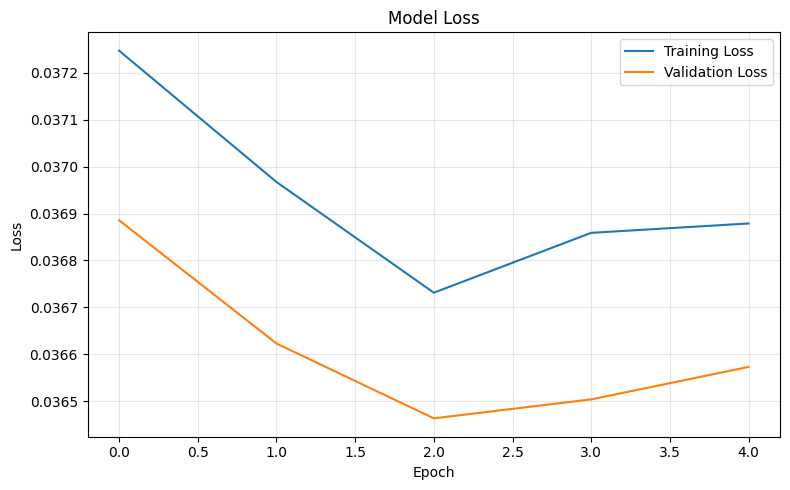

Final Training Loss: 0.0369
Final Validation Loss: 0.0366


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 1, figsize=(8, 5)) # Changed to 1 subplot as we only plot loss

# Loss plot
axes.plot(history.history['loss'], label='Training Loss')
axes.plot(history.history['val_loss'], label='Validation Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.set_title('Model Loss')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final loss
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
# model.evaluate returns a list of [total_loss, metric1, metric2, ...]
test_results = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Results:")
# The first element is the total loss, followed by metrics (in this case, only mae)
# Since we have multiple outputs, model.evaluate returns [total_loss, mae_output1, mae_output2, ...]
print(f"  Total Loss: {test_results[0]:.4f}")

# Get predictions
y_pred = model.predict(X_test, verbose=0)

# Calculate per-output metrics (MAE is already calculated by model.evaluate)
# We can extract the per-output MAE values from test_results
output_names = model.output_names
print("\nPer-Output Test MAE:")

# test_results[1:] contains the MAE for each output in order
# We'll iterate through the output names and pair them with the corresponding MAE from test_results
if len(test_results) > 1: # Check if metrics were returned by evaluate
    for i, name in enumerate(output_names):
        # The MAE for output 'i' is at index i+1 in the test_results list
        if i + 1 < len(test_results):
             print(f"  {name}: {test_results[i+1]:.4f}")
        else:
             print(f"  {name}: MAE not available in model.evaluate output.")
else:
    print("  Per-output MAE not available in model.evaluate output.")

Evaluating on test set...

Test Results:
  Total Loss: 0.0416

Per-Output Test MAE:
  arm_angle_degrees: 0.1246
  compression_depth_inches: MAE not available in model.evaluate output.
  compression_rate_bpm: MAE not available in model.evaluate output.
  hand_x_offset_inches: MAE not available in model.evaluate output.
  hand_y_offset_inches: MAE not available in model.evaluate output.
  torso_lean_degrees: MAE not available in model.evaluate output.
  hands_interlocked_score: MAE not available in model.evaluate output.
  compression_phase: MAE not available in model.evaluate output.
  overall_quality_score: MAE not available in model.evaluate output.
  metronome_bpm: MAE not available in model.evaluate output.
  metronome_volume: MAE not available in model.evaluate output.
  beat_alignment_score: MAE not available in model.evaluate output.
  next_beat_countdown: MAE not available in model.evaluate output.


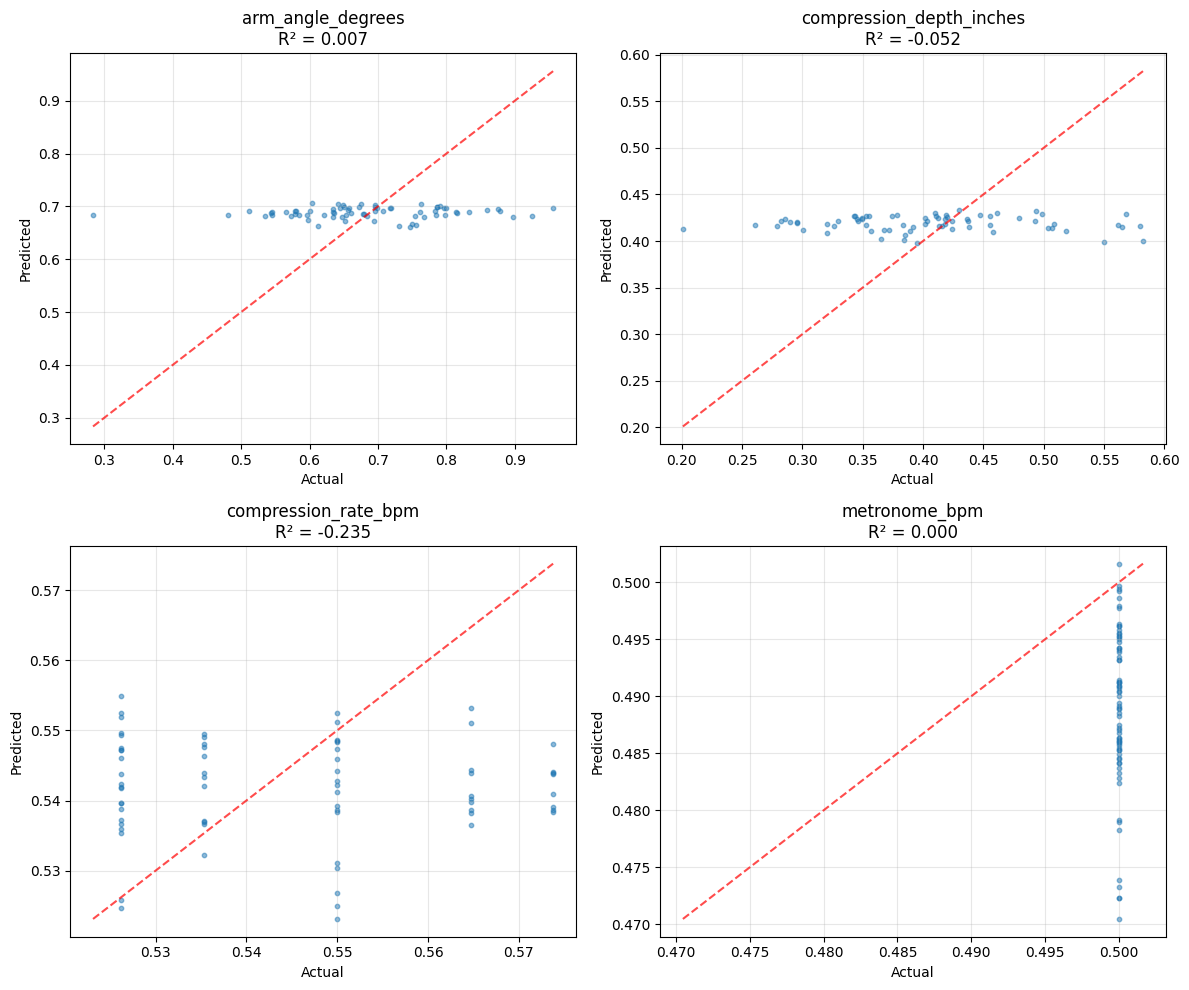

In [ ]:
# Select key metrics to visualize
key_metrics = [
    ("arm_angle_degrees", 0),
    ("compression_depth_inches", 1),
    ("compression_rate_bpm", 2),
    ("metronome_bpm", 9)
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (metric_name, idx) in zip(axes, key_metrics):
    # Scatter plot
    ax.scatter(y_test[:, idx], y_pred[:, idx], alpha=0.5, s=10)

    # Perfect prediction line
    min_val = min(y_test[:, idx].min(), y_pred[:, idx].min())
    max_val = max(y_test[:, idx].max(), y_pred[:, idx].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)

    # Calculate R²
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test[:, idx], y_pred[:, idx])

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{metric_name}\nR² = {r2:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save model in different formats with proper custom object registration
print("Saving model...")

# Method 1: Save Keras model with better compatibility
keras_path = model_dir / 'cpr_model.keras'

# Save with custom_object_scope to ensure proper serialization
try:
    # Define custom objects for saving
    def get_custom_objects():
        """Get custom objects needed for model serialization"""
        return {
            'CPRMetronomeModel': CPRMetronomeModel,
            'combined_loss': create_combined_loss(technique_weight=0.6, metronome_weight=0.4)
        }

    # Save the model with custom objects
    with tf.keras.utils.custom_object_scope(get_custom_objects()):
        model.save(str(keras_path), save_traces=False)
    print(f"  ✓ Saved Keras model to: {keras_path}")

except Exception as e:
    print(f"  Warning: Could not save .keras format: {e}")
    print("  Trying alternative save method...")

    # Alternative: Save in H5 format
    h5_path = model_dir / 'cpr_model.h5'
    model.save(str(h5_path), save_format='h5')
    print(f"  ✓ Saved H5 model to: {h5_path}")

# Method 2: Always save weights separately as backup
weights_path = model_dir / 'cpr_model_weights.weights.h5'
model.save_weights(str(weights_path))
print(f"  ✓ Saved weights to: {weights_path}")

# Method 3: Save model configuration for reconstruction if needed
import json
config_path = model_dir / 'model_config.json'
model_config = {
    'class_name': 'CPRMetronomeModel',
    'config': {
        'input_shape': [224, 224, 3],
        'num_outputs': 13
    }
}
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"  ✓ Saved model configuration to: {config_path}")

print("\nModel saved successfully in multiple formats!")
print("Files created:")
print(f"  - {keras_path} (main model file)")
print(f"  - {weights_path} (weights backup)")
print(f"  - {config_path} (model configuration)")

Saving model...
  Saved Keras model to: /content/models/cpr_model.keras
  Saved weights to: /content/models/cpr_model_weights.weights.h5


In [ ]:
# Register the model class for proper serialization
import tensorflow as tf
from tensorflow import keras

# Add decorator to make the model serializable
tf.keras.utils.register_keras_serializable(package="CPRModel")

In [ ]:
# Convert to TFLite for mobile/edge deployment
import pathlib

print("Converting to TFLite format...")

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Optimize for size (uncomment if needed)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save TFLite model in both locations
tflite_models_dir = pathlib.Path("/content/")
tflite_model_file = tflite_models_dir / 'model.tflite'
size_bytes = tflite_model_file.write_bytes(tflite_model)
print(f"  ✓ TFLite model size: {size_bytes / 1024 / 1024:.2f} MB")
print(f"  ✓ Saved to: {tflite_model_file}")

# Also save in the models directory
tflite_backup = model_dir / 'cpr_model.tflite'
tflite_backup.write_bytes(tflite_model)
print(f"  ✓ Backup saved to: {tflite_backup}")

Saved artifact at '/tmp/tmpm56sygrp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  132186526831952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526832144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526832912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526833872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526833680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526833104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526833488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526833296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526831376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526835024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132186526834832: Tensor